# HW4
Student name: PENG, Han
Student ID: 21035814

# Problem 1
For this problem we choose the cleaned dataset from Quanhua MU and Yoonhee Nam.
The snp data is stored in the ceph_hgdp_minor_code_XNA.betterAnnotated.csv and with 1043 columns represent different individuals and 488919 rows are the snp data for each people.

Here is screenshot of the csv file of the snp data. We can see that the first three columns are snp, chr, pos which are not directly related to our analysis so we can drop them.
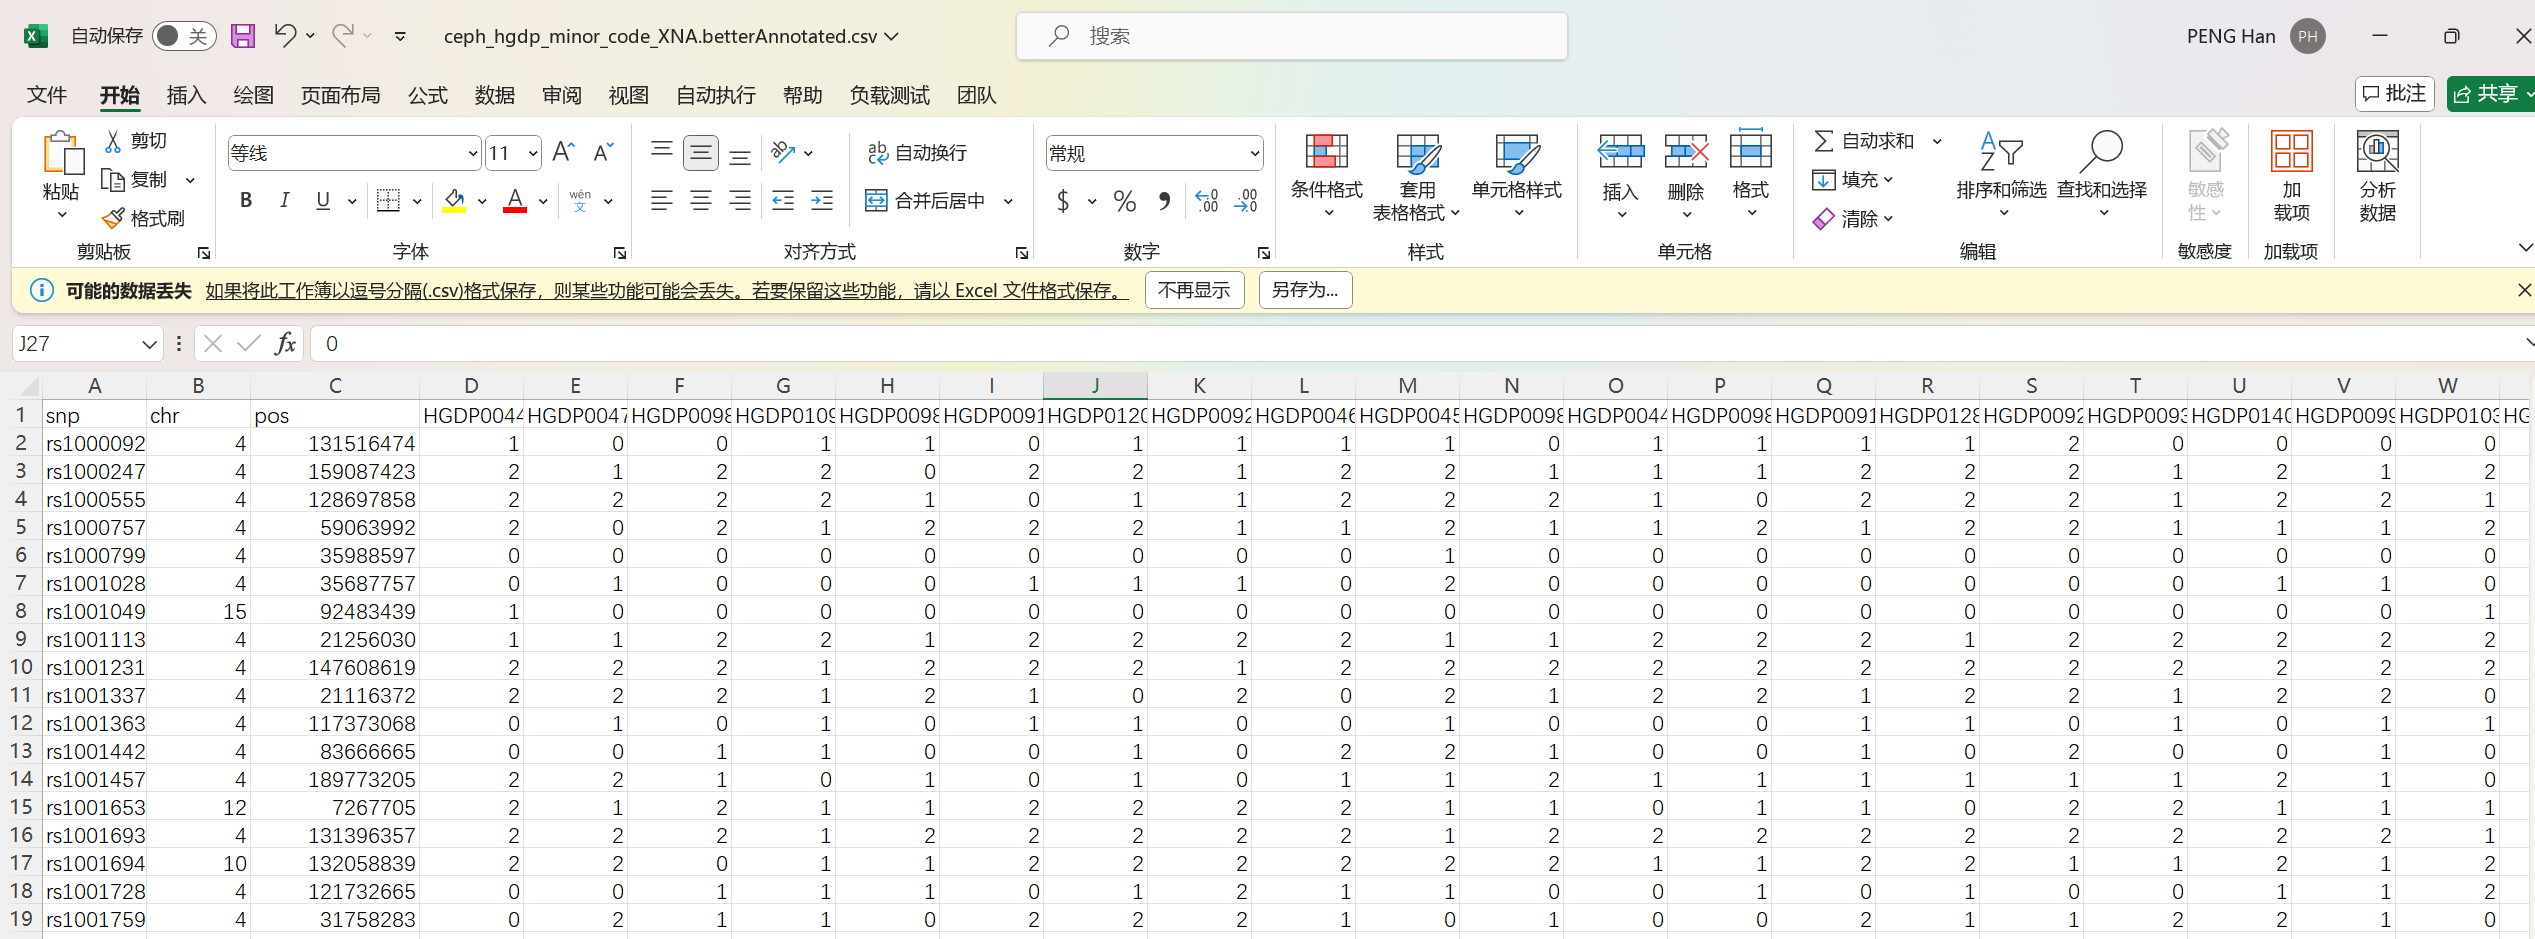

The ceph_hgdp_minor_code_XNA.sampleInformation.csv stores the region of each individual, we can extract a column vector of 1043 dimensions to represent this.

In [26]:
import pandas as pd
import numpy as np
from sklearn.random_projection import GaussianRandomProjection
import matplotlib.pyplot as plt

# Extract region of each people
sample_data = pd.read_csv('ceph_hgdp_minor_code_XNA.sampleInformation.csv')
regions = sample_data['region'].unique()

# For each region, extract index of individuals that are in this region.
region_idx = []
for region in regions:
    idx = sample_data[sample_data['region']==region].index # assign each region with the index of the individual 
    region_idx.append(idx)

In [31]:
# Load snp data of each people
snp = pd.read_csv('ceph_hgdp_minor_code_XNA.betterAnnotated.csv')

# drop first three columns and convert it to numpy.
X = snp.drop(columns=['snp', 'chr', 'pos']).to_numpy()
print(X.shape)

(488919, 1043)


In [41]:
import random
from sklearn.manifold import MDS

p, n = X.shape
k = 500

# Bernoulli random projection
if 0:
    R = np.zeros((k, p))
    for i in range(k):
        random_k = random.sample(range(p), k) # pick k integers from 0 to p-1
        R[i, random_k] = 1/k # set each row of R, when the index is in random_k, to be 1/k
    X_tr = np.dot(R, X) # transformed X
    X_tr = X_tr.T

# Gaussian random projection
projector = GaussianRandomProjection(n_components=k,eps=0.05)
X_tr = projector.fit_transform(X.T)

In [42]:
def my_mds(X, n_components=2):

    distances = np.linalg.norm(X[:, np.newaxis] - X, axis=-1)

    # Centering the dissimilarity matrix
    n_samples = X.shape[0]
    J = np.eye(n_samples) - np.ones((n_samples, n_samples))/n_samples
    B = -0.5 * np.dot(J, np.dot(distances**2, J))

    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(B)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Compute the output representation
    Y = eigenvectors[:, :n_components] * np.sqrt(eigenvalues[:n_components])

    return Y

X_mds = my_mds(X_tr, n_components=2)


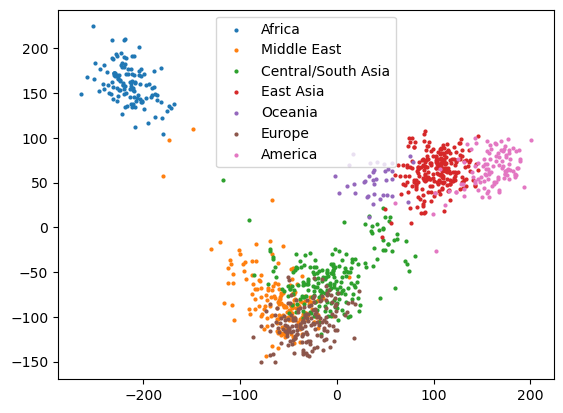

In [43]:
for i in range(len(regions)):
    plt.scatter(X_mds[region_idx[i],0],X_mds[region_idx[i],1],label=regions[i],s=4)
plt.legend()
plt.show()

# Problem 2

In [45]:
import cvxpy as cp

d=20
p = np.zeros((d,d))

for n in range(d):
    for k in range(d):
       
        count=0
        for _ in range(50):

            # (1) Construct a spare vector
            x0 = np.zeros(d)
            idx = np.random.choice(range(d), k+1, replace=False)
            values = np.random.choice([-1,1], k+1)
            x0[idx] = values
            
            # (2) Draw a Gaussian random matrix
            A = np.random.normal(0, 1, size=(n+1, d))
            b = np.matmul(A,x0)

            # (3) Solve LP problem
            x = cp.Variable(d)
            constraints = [A@x==b]
            objective = cp.Minimize(cp.sum(cp.abs(x)))
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # (4) Declare success
            if problem.status not in ["infeasible", "unbounded"]:
                if np.linalg.norm(x.value - x0, ord=2) <= 1e-3:
                    count = count + 1

        p[n,k] = count/50


c:\f\Programfiles\Anaconda\envs\mdn\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


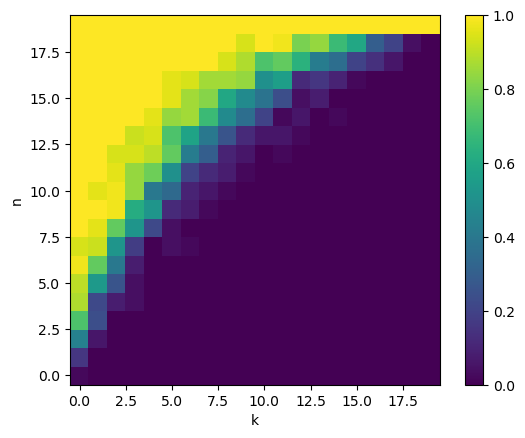

In [47]:
plt.imshow(p, origin='lower')
plt.colorbar()
plt.xlabel('k')
plt.ylabel('n')
plt.show()

The code above tries to use L1 regularization to solve the compressed sensing problem.
We can see that when the non-sparsity level k is fixed, if we have number of data points n larger than k, we will have a high chance of success.
It is noticeable that when k is small and n is large, we are going to be 100% successful in the algorithm.